In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

In [ ]:
# test original CartPoleEnv
import gymnasium as gym
from gymnasium.envs.classic_control.cartpole import CartPoleEnv
# env = gym.make("CartPole-v1", render_mode='human')

env = CartPoleEnv(render_mode='human')
observation, info = env.reset(seed=42)
for _ in range(100):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        observation, info = env.reset()
env.close()

Epoch 1/50, Loss: 0.137184, Test Loss: 0.033433
Epoch 2/50, Loss: 0.019545, Test Loss: 0.007527
Epoch 3/50, Loss: 0.006481, Test Loss: 0.003855
Epoch 4/50, Loss: 0.004082, Test Loss: 0.002615
Epoch 5/50, Loss: 0.002724, Test Loss: 0.002389
Epoch 6/50, Loss: 0.001825, Test Loss: 0.000945
Epoch 7/50, Loss: 0.001201, Test Loss: 0.000866
Epoch 8/50, Loss: 0.000816, Test Loss: 0.000389
Epoch 9/50, Loss: 0.000593, Test Loss: 0.000406
Epoch 10/50, Loss: 0.000457, Test Loss: 0.000352
Epoch 11/50, Loss: 0.000380, Test Loss: 0.000264
Epoch 12/50, Loss: 0.000326, Test Loss: 0.000262
Epoch 13/50, Loss: 0.000286, Test Loss: 0.000182
Epoch 14/50, Loss: 0.000253, Test Loss: 0.000183
Epoch 15/50, Loss: 0.000230, Test Loss: 0.000190
Epoch 16/50, Loss: 0.000204, Test Loss: 0.000145
Epoch 17/50, Loss: 0.000187, Test Loss: 0.000172
Epoch 18/50, Loss: 0.000170, Test Loss: 0.000159
Epoch 19/50, Loss: 0.000158, Test Loss: 0.000137
Epoch 20/50, Loss: 0.000143, Test Loss: 0.000144
Epoch 21/50, Loss: 0.000130, 

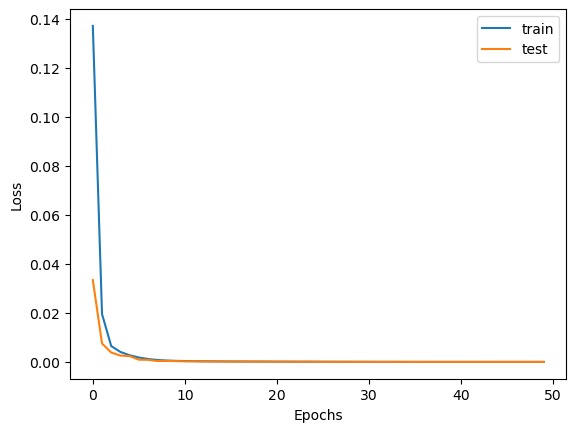

Model training completed successfully. Weights have been saved.


In [5]:
import gymnasium as gym
from models.feedforward_nn import FeedforwardNN
from random_exploration import random_exploration
from train import create_dataloader, train_model

import torch
import os

env = gym.make("CartPole-v1")

# Hyperparameters
NUM_TRAJECTORIES = 100
HORIZON = 50
BATCH_SIZE = 25
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 64

# Collect data from the environment
states, actions, next_states = random_exploration(env, NUM_TRAJECTORIES, HORIZON)
# Create DataLoader for training
train_dataloader = create_dataloader(states, actions, next_states, BATCH_SIZE)
# Collect data for test set
states, actions, next_states = random_exploration(env, 1, 500)
# Create DataLoader for training
test_dataloader = create_dataloader(states, actions, next_states, 500)

# Initialize the dynamics model
state_dim = env.observation_space.shape[0]
action_dim = 1
model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

# Train the model
train_model(model, train_dataloader, test_dataloader, NUM_EPOCHS, LEARNING_RATE)

# Ensure the 'weights' directory exists
os.makedirs('../weights', exist_ok=True)

# Save the trained model
torch.save(model.state_dict(), '../weights/baseline_model_cartpole.pth')
print("Model training completed successfully. "
      "Weights have been saved.")

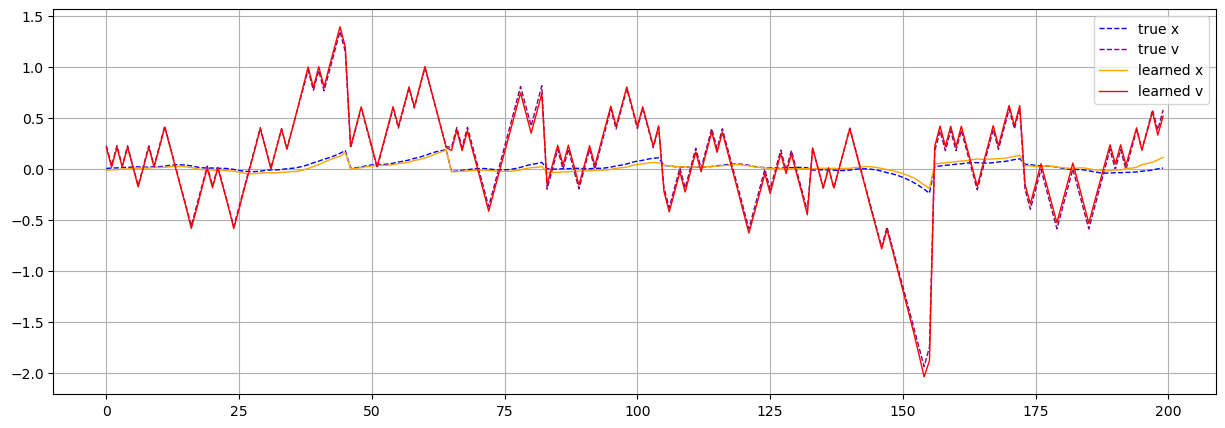

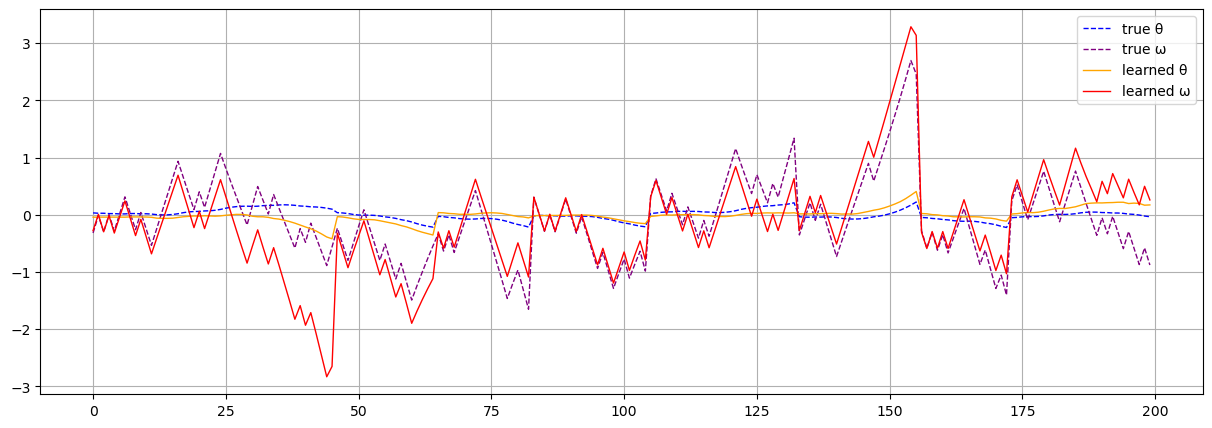

In [7]:
# test model
from dynamical_systems.ModelBasedCartPole import ModelBasedCartPoleEnv

import numpy as np
import pygame
import matplotlib.pyplot as plt

# set random seed to get same test trajectory
test_seed = 44

if __name__ == "__main__":
    # original dynamic
    env = CartPoleEnv(render_mode='human')
    env.reset()
    
    # Initialize trained dynamics model
    state_dim = env.observation_space.shape[0]
    action_dim = 1
    trained_model = FeedforwardNN(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

    # load saved weights
    trained_model.load_state_dict(torch.load('../weights/baseline_model_cartpole.pth'))
    trained_model.eval()

    # learned dynamic
    trained_env = ModelBasedCartPoleEnv(trained_model)
    trained_env.reset()
    env.action_space.seed(test_seed)
    trained_env.action_space.seed(test_seed)

    save = [[],[]]

    for _ in range(200):
        action = env.action_space.sample()
        obs, _, d_true, _, _= env.step(action)
        save[0].append(obs)
        obs, _, d_trained, _, _= trained_env.step(action)
        save[1].append(obs)
        if d_true or d_trained:
            obs,_ = env.reset()
            obs,_ = trained_env.reset()

    saved_traj = np.array(save)
    plt.figure(1, (15,5))
    plt.plot(saved_traj[0,:,0], label="true x", color="blue", linestyle="--", linewidth=1)
    plt.plot(saved_traj[0,:,1], label="true v", color="purple", linestyle="--", linewidth=1)
    plt.plot(saved_traj[1,:,0], label="learned x", color="orange", linewidth=1)
    plt.plot(saved_traj[1,:,1], label="learned v", color="red", linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure(2, (15,5))
    plt.plot(saved_traj[0,:,2], label="true θ", color="blue", linestyle="--", linewidth=1)
    plt.plot(saved_traj[0,:,3], label="true ω", color="purple", linestyle="--", linewidth=1)
    plt.plot(saved_traj[1,:,2], label="learned θ", color="orange", linewidth=1)
    plt.plot(saved_traj[1,:,3], label="learned ω", color="red", linewidth=1)
    plt.legend()
    plt.grid(True)
    plt.show()
